In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

pd.set_option('display.max_rows', 50)
%matplotlib inline

## Load rating data

In [12]:
path = 'data/ml-10M100K/'  # ML-10M files
all_files = glob.glob(os.path.join(path, "ratings*.csv"))
ratings = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

### Get number of ratings per movie

In [13]:
rating_counts = ratings.groupby('movieId').agg({'rating':'count'}).reset_index()
rating_counts.columns = ['movieId', 'n_ratings']
rating_counts.head()

,movieId,n_ratings
0,0,2412
1,1,14975
2,2,17851
3,3,16075
4,4,18925


In [14]:
movies = pd.read_csv(path+'movies.tsv', sep='\t')
movies = pd.merge(movies, rating_counts, how='inner', on='movieId')
movies.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,n_ratings
0,0,Boomerang (1992),0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,2412
1,1,"Net, The (1995)",1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,14975
2,2,Dumb & Dumber (1994),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,17851
3,3,Outbreak (1995),1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,16075
4,4,Stargate (1994),1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,18925


In [19]:
# top rated movies
movies.sort_values('n_ratings', ascending=False).head(10)

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,n_ratings
1008,1008,Pulp Fiction (1994),0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,34864
7,7,Forrest Gump (1994),0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,34457
139,139,"Silence of the Lambs, The (1991)",0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,33668
14,14,Jurassic Park (1993),1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,32631
1293,1293,"Shawshank Redemption, The (1994)",0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,31126
22,22,Braveheart (1995),1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,29154
175,175,"Fugitive, The (1993)",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,28951
19,19,Terminator 2: Judgment Day (1991),1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,28948
24,24,Star Wars: Episode IV - A New Hope (a.k.a. Sta...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,28566
74,74,Apollo 13 (1995),0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,27035


# 1. Embeddings PCA
[How to annotate scatterplot](https://python-graph-gallery.com/46-add-text-annotation-on-scatterplot/)

In [20]:
emb = pd.read_csv(path+'embeddings.csv')
emb.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,e190,e191,e192,e193,e194,e195,e196,e197,e198,e199
0,0,Boomerang (1992),0,0,0,0,1,0,0,0,...,0.087806,0.127755,0.020493,0.033983,-0.116912,-0.012477,-0.045383,0.007603,0.150989,-0.148305
1,1,"Net, The (1995)",1,0,0,0,0,1,0,0,...,0.077832,0.008988,0.014570,0.073239,0.124648,-0.134136,-0.114936,0.071621,0.278991,0.044786
2,2,Dumb & Dumber (1994),0,0,0,0,1,0,0,0,...,-0.046292,-0.049686,0.218707,-0.030238,-0.197417,-0.022804,0.056282,-0.186790,-0.039575,-0.325568
3,3,Outbreak (1995),1,0,0,0,0,0,0,1,...,0.010315,0.058355,-0.088681,0.181235,0.037869,0.079277,0.070823,0.164783,0.237280,0.022873
4,4,Stargate (1994),1,1,0,0,0,0,0,0,...,-0.065126,0.078158,-0.027330,0.022515,0.092744,0.284196,-0.122310,0.033767,-0.013537,0.319222


In [21]:
from sklearn.decomposition import PCA

In [22]:
# compute PCA to get first two components
pca = PCA(n_components=2)
# add pc1 and pc2 to emb dataframe
emb[['pc1', 'pc2']] = pd.DataFrame(pca.fit_transform(emb.iloc[:,-200:]), columns=['pc1', 'pc2'])

emb.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,e192,e193,e194,e195,e196,e197,e198,e199,pc1,pc2
0,0,Boomerang (1992),0,0,0,0,1,0,0,0,...,0.020493,0.033983,-0.116912,-0.012477,-0.045383,0.007603,0.150989,-0.148305,0.733743,-0.413726
1,1,"Net, The (1995)",1,0,0,0,0,1,0,0,...,0.014570,0.073239,0.124648,-0.134136,-0.114936,0.071621,0.278991,0.044786,1.060578,-0.808904
2,2,Dumb & Dumber (1994),0,0,0,0,1,0,0,0,...,0.218707,-0.030238,-0.197417,-0.022804,0.056282,-0.186790,-0.039575,-0.325568,0.368845,0.118453
3,3,Outbreak (1995),1,0,0,0,0,0,0,1,...,-0.088681,0.181235,0.037869,0.079277,0.070823,0.164783,0.237280,0.022873,0.752705,-0.836049
4,4,Stargate (1994),1,1,0,0,0,0,0,0,...,-0.027330,0.022515,0.092744,0.284196,-0.122310,0.033767,-0.013537,0.319222,0.550180,-0.561947


In [32]:
df = pd.merge(movies, emb[['movieId', 'pc1', 'pc2']], how='inner', on='movieId')
df.head()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,n_ratings,pc1,pc2
0,0,Boomerang (1992),0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,2412,0.733743,-0.413726
1,1,"Net, The (1995)",1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,14975,1.060578,-0.808904
2,2,Dumb & Dumber (1994),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,17851,0.368845,0.118453
3,3,Outbreak (1995),1,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,16075,0.752705,-0.836049
4,4,Stargate (1994),1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,18925,0.550180,-0.561947


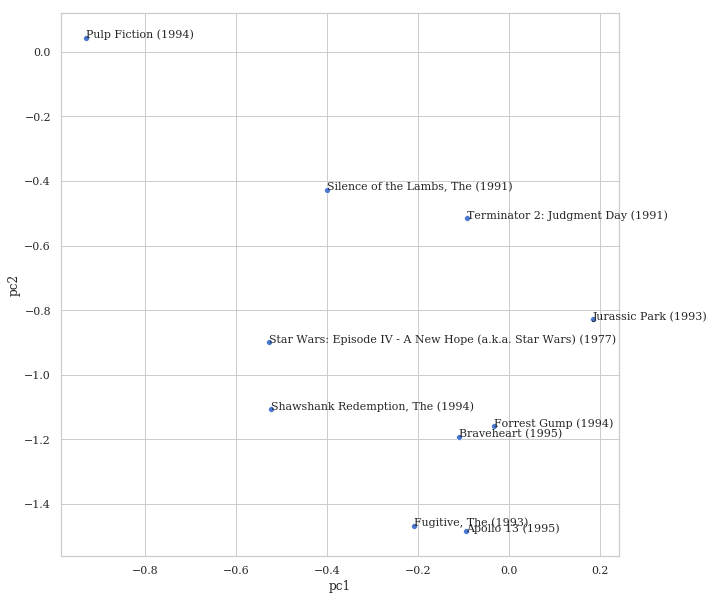

In [38]:
top_10 = df.sort_values('n_ratings', ascending=False).head(10)
sns.scatterplot(x='pc1', y='pc2', data=top_10)
# plt.xlim(-1.5,1.5)
# plt.ylim(-1.5,1.5)
for idx, row in top_10.iterrows():
    plt.text(row.pc1, row.pc2, row.title, fontsize=11)

In [26]:
lotr = df[df.title.str.contains('Lord of the Rings') & ~df.title.str.contains('1978')]
hp = df[df.title.str.contains('Harry Potter')]
sw = df[df.title.str.contains('Star Wars')]
gf = df[df.title.str.contains('Godfather, The') | df.title.str.contains('Godfather: Part II')]

In [30]:
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (10,10),
            'font.family': 'serif'})

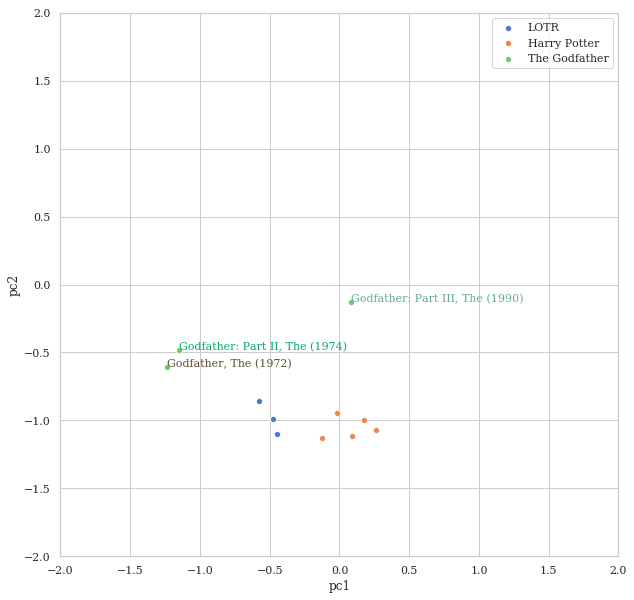

In [31]:
sns.scatterplot(x='pc1', y='pc2', data=lotr, label='LOTR')
sns.scatterplot(x='pc1', y='pc2', data=hp, label='Harry Potter')
# sns.scatterplot(x='pc1', y='pc2', data=sw, label='Star Wars')
sns.scatterplot(x='pc1', y='pc2', data=gf, label='The Godfather')
for idx, row in gf.iterrows():
    plt.text(row.pc1, row.pc2, row.title, color=np.random.rand(3)*0.7, fontsize=11)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.legend()

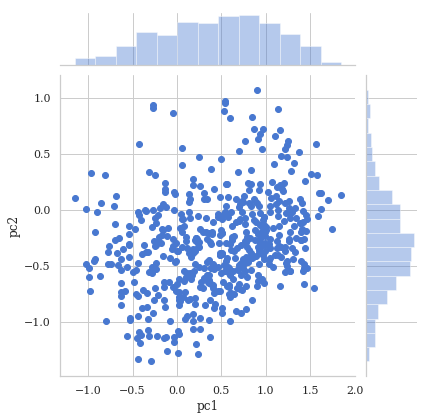

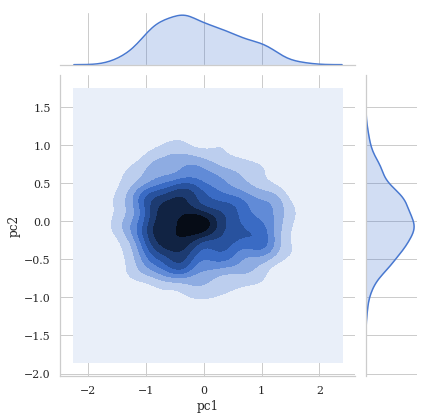

In [40]:
sns.jointplot(x='pc1', y='pc2', data=emb[emb['Children']==1], label='Children')
sns.jointplot(x='pc1', y='pc2', data=emb[emb['Crime']==1], kind='kde', label='Action')

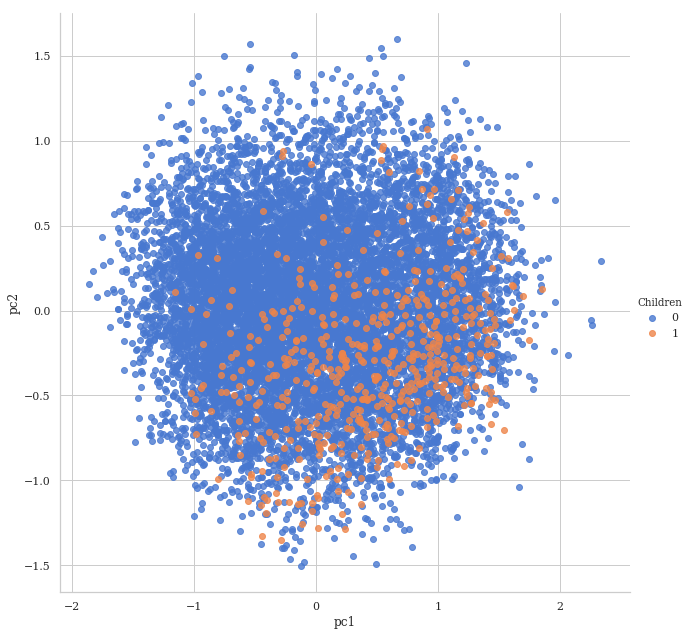

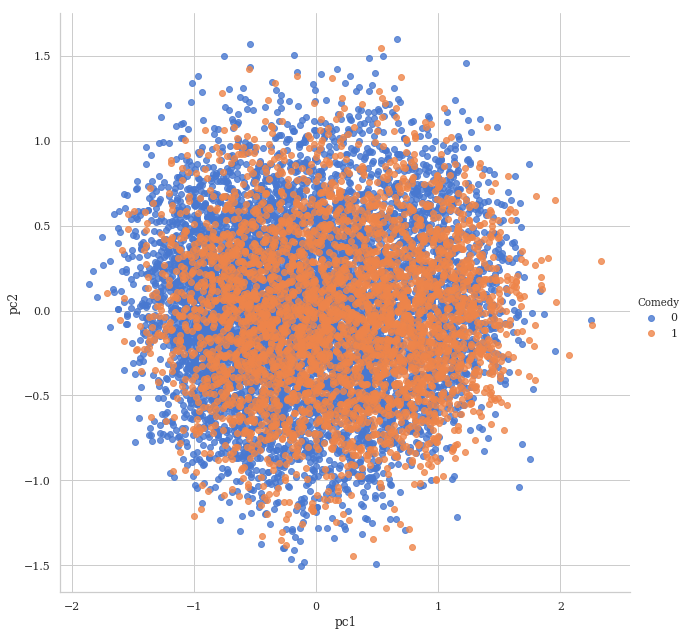

In [41]:
sns.lmplot(x='pc1', y='pc2', data=emb, hue='Children', fit_reg=False, size=9)
sns.lmplot(x='pc1', y='pc2', data=emb, hue='Comedy', fit_reg=False, size=9)

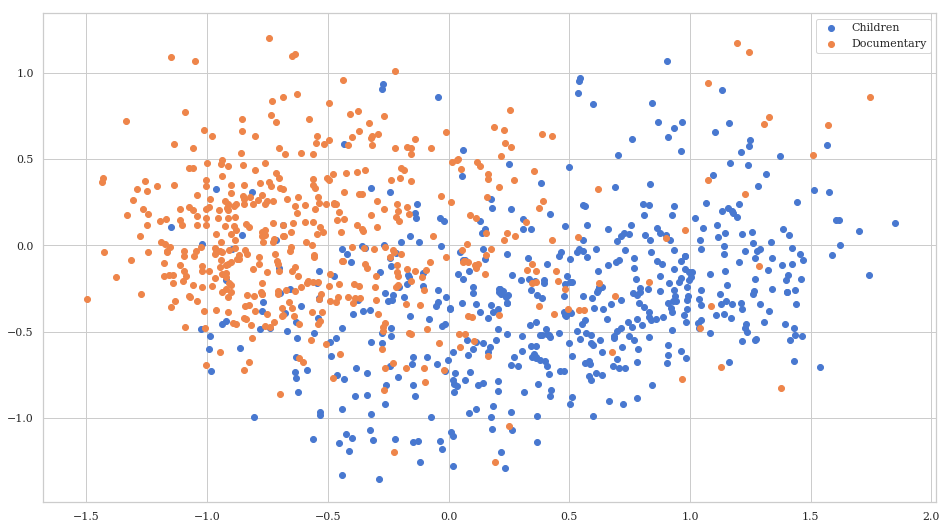

In [42]:
plt.scatter(x=emb[emb['Children']==1].pc1, y=emb[emb['Children']==1].pc2, label='Children')
plt.scatter(x=emb[emb['Documentary']==1].pc1, y=emb[emb['Documentary']==1].pc2, label='Documentary')
plt.legend()

In [43]:
sns.set(rc={'figure.figsize': (10,9)})

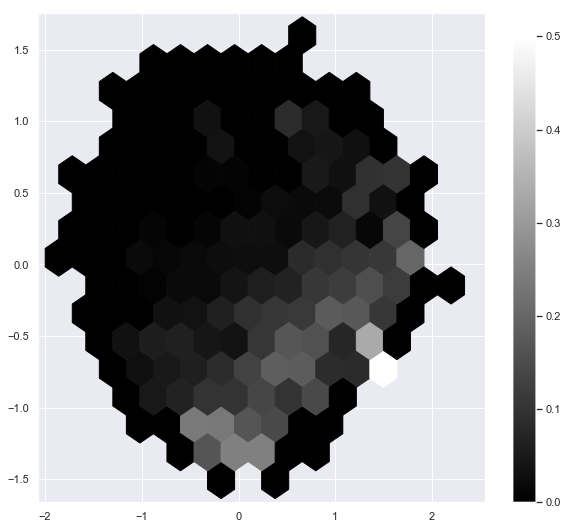

In [44]:
plt.hexbin(x=emb.pc1, y=emb.pc2, C=emb.Children, gridsize=15, cmap='gist_gray', mincnt=1)
plt.colorbar(spacing='uniform', extend='max')